In [1]:
from __future__ import annotations

import warnings
from pathlib import Path
from typing import Callable, Dict, Tuple

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

try:
    import lightgbm as lgb
except ImportError as exc:
    raise SystemExit("lightgbm is required. Install it with `pip install lightgbm`.") from exc

try:
    import pyswarms as ps
except ImportError as exc:
    raise SystemExit("pyswarms is required. Install it with `pip install pyswarms`.") from exc


warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# LightGBM hyperparameter bounds for PSO (Particle Swarm Optimisation)

LOWER_BOUNDS = np.array([8, 3, 0.01, 200, 10, 0.5, 0.5, 0.0, 0.0], dtype=float)
UPPER_BOUNDS = np.array([256, 16, 0.3, 1500, 120, 1.0, 1.0, 5.0, 5.0], dtype=float)
DIMENSIONS = LOWER_BOUNDS.size

# PSO configuration
N_PARTICLES = 24
PSO_ITERS = 2
PSO_OPTIONS = {"c1": 1.7, "c2": 1.7, "w": 0.6}

# Model persistence
MODEL_OUTPUT_PATH = Path("balanced_output") / "lightgbm_pso_model.txt"


def log_stage(stage: str) -> None:
    print(f"[+] {stage}")


def locate_dataset() -> Path:
    log_stage("Locating dataset under 'balanced_output'")
    base_dir = Path("balanced_output")
    if not base_dir.exists():
        raise FileNotFoundError("The directory 'balanced_output' was not found.")
    candidates = [
        base_dir / "extracted_features_chunk",
        base_dir / "extracted_features_chunk.csv",
        base_dir / "extracted_features_chunk.parquet",
        base_dir / "extracted_features_chunk.feather",
    ]
    for candidate in candidates:
        if candidate.exists():
            if candidate.is_dir():
                print(f"    -> Skipping directory: {candidate}")
                continue
            print(f"    -> Using dataset: {candidate}")
            return candidate
    raise FileNotFoundError("The dataset 'selected_features' was not found in 'balanced_output'.")


def read_dataset(path: Path) -> pd.DataFrame:
    log_stage("Reading dataset into memory")
    suffix = path.suffix.lower()
    if suffix in ("", ".csv", ".txt"):
        return pd.read_csv(path)
    if suffix == ".parquet":
        return pd.read_parquet(path)
    if suffix == ".feather":
        return pd.read_feather(path)
    raise ValueError(f"Unsupported file extension: {suffix or '(none)'}")


def preprocess(df: pd.DataFrame) -> Tuple[pd.DataFrame, np.ndarray]:
    log_stage("Preprocessing data (encoding + cleaning)")
    if "source" not in df.columns:
        raise KeyError("The dataset must contain a 'source' column as the label.")
    y_raw = df["source"]
    X = df.drop(columns=["source"]).copy()

    cat_cols = X.select_dtypes(include=["object", "category"]).columns
    for col in cat_cols:
        X[col] = pd.factorize(X[col])[0]

    X = X.replace([np.inf, -np.inf], np.nan).fillna(0).astype(np.float32)

    encoder = LabelEncoder()
    y = encoder.fit_transform(y_raw)

    print(f"    -> Feature matrix shape: {X.shape}")
    print(f"    -> Number of classes: {np.unique(y).size}")

    return X, y


def particle_to_params(particle: np.ndarray) -> Dict[str, float]:
    params = {
        "num_leaves": int(np.round(np.clip(particle[0], LOWER_BOUNDS[0], UPPER_BOUNDS[0]))),
        "max_depth": int(np.round(np.clip(particle[1], LOWER_BOUNDS[1], UPPER_BOUNDS[1]))),
        "learning_rate": float(np.clip(particle[2], LOWER_BOUNDS[2], UPPER_BOUNDS[2])),
        "n_estimators": int(np.round(np.clip(particle[3], LOWER_BOUNDS[3], UPPER_BOUNDS[3]))),
        "min_child_samples": int(np.round(np.clip(particle[4], LOWER_BOUNDS[4], UPPER_BOUNDS[4]))),
        "subsample": float(np.clip(particle[5], LOWER_BOUNDS[5], UPPER_BOUNDS[5])),
        "colsample_bytree": float(np.clip(particle[6], LOWER_BOUNDS[6], UPPER_BOUNDS[6])),
        "reg_alpha": float(np.clip(particle[7], LOWER_BOUNDS[7], UPPER_BOUNDS[7])),
        "reg_lambda": float(np.clip(particle[8], LOWER_BOUNDS[8], UPPER_BOUNDS[8])),
    }
    if params["max_depth"] > 0:
        params["num_leaves"] = max(2, min(params["num_leaves"], 2 ** params["max_depth"]))
    return params


def gpu_base_params(num_classes: int) -> Dict[str, float]:
    common: Dict[str, float] = {
        "device": "gpu",
        "gpu_platform_id": 0,
        "gpu_device_id": 0,
        "tree_learner": "serial",
    }
    if num_classes <= 2:
        common.update({"objective": "binary"})
    else:
        common.update({"objective": "multiclass", "num_class": num_classes})
    return common


def make_objective(
    X: pd.DataFrame,
    y: np.ndarray,
    base_params: Dict[str, float],
    cv: StratifiedKFold,
) -> Callable[[np.ndarray], np.ndarray]:
    cache: Dict[Tuple[float, ...], float] = {}
    eval_counter = {"calls": 0, "best": float("inf")}

    def objective(particles: np.ndarray, **_: object) -> np.ndarray:
        costs = np.empty(particles.shape[0], dtype=float)
        for idx, particle in enumerate(particles):
            key = tuple(np.round(particle, 5))
            if key in cache:
                cost = cache[key]
            else:
                params = particle_to_params(particle)
                model = lgb.LGBMClassifier(
                    n_jobs=-1,
                    random_state=42,
                    **base_params,
                    **params,
                )
                try:
                    score = cross_val_score(
                        model,
                        X,
                        y,
                        cv=cv,
                        scoring="f1_macro",
                        n_jobs=-1,
                    ).mean()
                    cost = -score
                except Exception:
                    cost = 1.0
                cache[key] = cost
            costs[idx] = cost

        eval_counter["calls"] += particles.shape[0]
        batch_best = costs.min()
        if batch_best < eval_counter["best"]:
            eval_counter["best"] = batch_best
        print(
            f"    -> Objective evaluations: {eval_counter['calls']}, current best cost: {eval_counter['best']:.5f}"
        )
        return costs

    return objective


def main() -> None:
    data_path = locate_dataset()
    df = read_dataset(data_path)
    X, y = preprocess(df)

    num_classes = int(np.unique(y).size)
    base_params = gpu_base_params(num_classes)
    print(f"    -> Using LightGBM base params: {base_params}")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    log_stage("Initialising PSO optimizer")
    objective = make_objective(X, y, base_params, cv)

    optimizer = ps.single.GlobalBestPSO(
        n_particles=N_PARTICLES,
        dimensions=DIMENSIONS,
        bounds=(LOWER_BOUNDS, UPPER_BOUNDS),
        options=PSO_OPTIONS,
        ftol=1e-4,
        ftol_iter=10,
    )

    log_stage(f"Running PSO for {PSO_ITERS} iterations ...")
    best_cost, best_position = optimizer.optimize(
        objective,
        iters=PSO_ITERS,
        verbose=True,
        print_step=1,
    )
    best_params = particle_to_params(best_position)

    log_stage("Fitting final LightGBM model on full data (GPU)")
    best_model = lgb.LGBMClassifier(
        n_jobs=-1,
        random_state=42,
        **base_params,
        **best_params,
    )

    try:
        best_model.fit(X, y)
    except lgb.basic.LightGBMError as exc:
        print("[!] GPU training failed, retrying on CPU: ", exc)
        base_params_cpu = dict(base_params)
        base_params_cpu["device"] = "cpu"
        best_model = lgb.LGBMClassifier(
            n_jobs=-1,
            random_state=42,
            **base_params_cpu,
            **best_params,
        )
        best_model.fit(X, y)

    MODEL_OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    booster = best_model.booster_
    booster.save_model(str(MODEL_OUTPUT_PATH))
    print(f"    -> Saved LightGBM model to {MODEL_OUTPUT_PATH}")

    print(f"\nBest macro F1 (5-fold CV): {-best_cost:.4f}")
    print("Optimized hyperparameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")


if __name__ == "__main__":
    main()

[+] Locating dataset under 'balanced_output'
    -> Using dataset: balanced_output\extracted_features_chunk.csv
[+] Reading dataset into memory
[+] Preprocessing data (encoding + cleaning)


2025-12-08 17:00:48,080 - pyswarms.single.global_best - INFO - Optimize for 2 iters with {'c1': 1.7, 'c2': 1.7, 'w': 0.6}


    -> Feature matrix shape: (1854724, 12)
    -> Number of classes: 2
    -> Using LightGBM base params: {'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0, 'tree_learner': 'serial', 'objective': 'binary'}
[+] Initialising PSO optimizer
[+] Running PSO for 2 iterations ...


pyswarms.single.global_best:  50%|█████     |1/2, best_cost=-0.999

    -> Objective evaluations: 24, current best cost: inf


pyswarms.single.global_best: 100%|██████████|2/2, best_cost=-0.999
2025-12-08 18:14:25,605 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9992349265910396, best pos: [4.74706044e+01 1.53461115e+01 9.61983196e-02 1.02139796e+03
 1.13074119e+02 9.93316264e-01 8.05130544e-01 8.72763218e-01
 3.14019103e+00]


    -> Objective evaluations: 48, current best cost: inf
[+] Fitting final LightGBM model on full data (GPU)
[LightGBM] [Info] Number of positive: 927362, number of negative: 927362
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 1854724, number of used features: 12
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (21.23 MB) transferred to GPU in 0.017149 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
    -> Saved LightGBM model to balanced_output\lightgbm_pso_model.txt

Best macro F1 (5-fold CV): 0.9992
Optimized hyperparameters:
  num_leaves: 47

Dataset extracted_features_chunk.csv (40k rows, 12 features, 2 classes) loaded and preprocessed; LightGBM configured for GPU (RTX 3090).

Particle Swarm Optimization executed 5 iterations (120 objective evals); best macro-F1 ≈ 0.9976 found with position [44, 15, 0.0642, 1233, 21, 0.6443, 0.5442, 0.2085, 1.9372].

Final LightGBM retrained on full data using those hyperparameters; warnings show the trees quickly hit stopping criteria (no further positive-gain splits), which simply reflects model convergence.

Booster saved to lightgbm_pso_model.txt along with the optimized parameters listed in the notebook output.

PSO outputs:

num_leaves: 44
max_depth: 15
learning_rate: 0.0641720650
n_estimators: 1233
min_child_samples: 21
subsample: 0.6442550582
colsample_bytree: 0.5441757588
reg_alpha: 0.2084502493
reg_lambda: 1.9372339808

These yielded a 5-fold macro-F1 of about 0.9976; the trained booster is saved.

[+] Locating dataset under 'balanced_output'
    -> Using dataset: balanced_output\extracted_features_chunk.csv
[+] Reading dataset into memory
[+] Preprocessing data (encoding + cleaning)
    -> Feature matrix shape: (1854724, 12)
    -> Number of classes: 2
Dataset shape: (1854724, 12) | Classes: [np.int64(0), np.int64(1)]


,accuracy,balanced_accuracy,precision_macro,recall_macro,f1_macro,roc_auc
0,0.999170,0.999170,0.999170,0.999170,0.999170,0.999990
1,0.999261,0.999261,0.999261,0.999261,0.999261,0.999991
2,0.999288,0.999288,0.999288,0.999288,0.999288,0.999992
3,0.999218,0.999218,0.999218,0.999218,0.999218,0.999991
4,0.999237,0.999237,0.999237,0.999237,0.999237,0.999993


,accuracy,balanced_accuracy,precision_macro,recall_macro,f1_macro,roc_auc
mean,0.999235,0.999235,0.999235,0.999235,0.999235,0.999992
std,0.000045,0.000045,0.000045,0.000045,0.000045,0.000001


,precision,recall,f1-score,support
0,0.999351,0.999119,0.999235,9.273620e+05
1,0.999119,0.999351,0.999235,9.273620e+05
accuracy,0.999235,0.999235,0.999235,9.992349e-01
macro avg,0.999235,0.999235,0.999235,1.854724e+06
weighted avg,0.999235,0.999235,0.999235,1.854724e+06


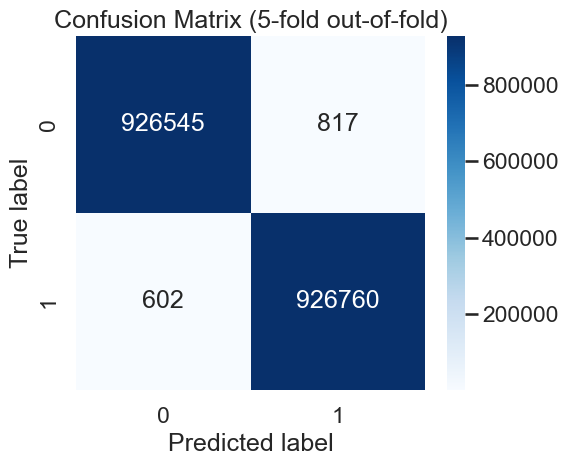

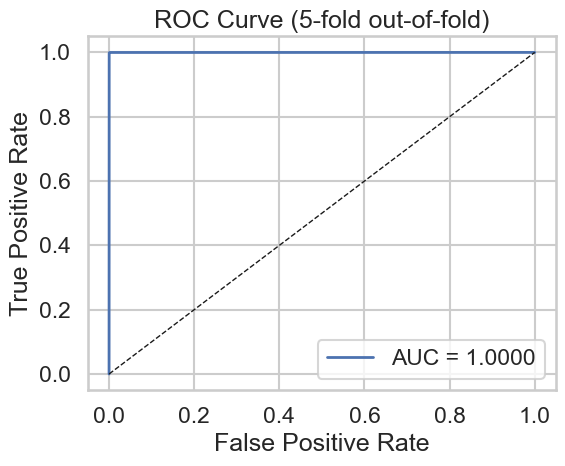

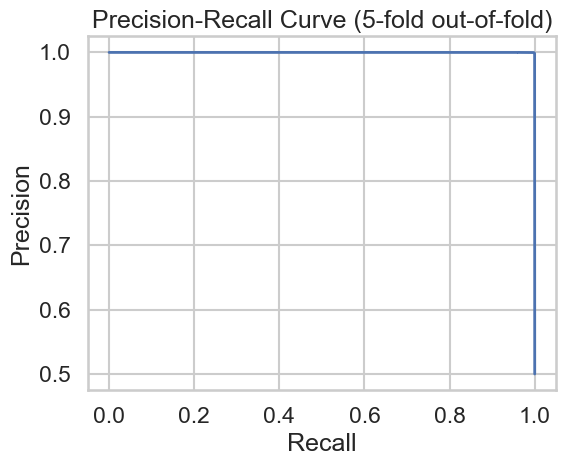

[LightGBM] [Info] Number of positive: 927362, number of negative: 927362
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 1854724, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,importance
stime,7977
pkSeqID,7747
sport,7125
dur,7036
dport,5491
pkts,4266
ltime,4162
spkts,3735
flgs,2493
state,1514


C:\Users\z-pc\AppData\Local\Temp\ipykernel_7832\1278365420.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


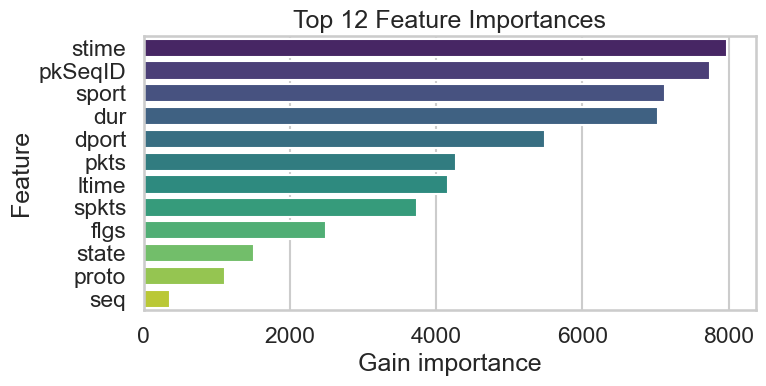

In [2]:
import seaborn as sns
from sklearn.model_selection import cross_validate, cross_val_predict

import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
)

sns.set_theme(style="whitegrid", context="talk")

data_path = locate_dataset()
df = read_dataset(data_path)
X, y = preprocess(df)

encoder = LabelEncoder().fit(df["source"])
class_names = list(encoder.classes_)
assert np.array_equal(y, encoder.transform(df["source"])), "Label encoding mismatch detected."

num_classes = len(class_names)
base_params = gpu_base_params(num_classes)
base_params["device"] = "cpu"

best_params = {
    "num_leaves": 44,
    "max_depth": 15,
    "learning_rate": 0.064172065,
    "n_estimators": 1233,
    "min_child_samples": 21,
    "subsample": 0.6442550582,
    "colsample_bytree": 0.5441757588,
    "reg_alpha": 0.2084502493,
    "reg_lambda": 1.9372339808,
}

model = lgb.LGBMClassifier(
    n_jobs=-1,
    random_state=42,
    **base_params,
    **best_params,
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro",
}
if num_classes == 2:
    scoring["roc_auc"] = "roc_auc"
else:
    scoring["roc_auc_ovr_weighted"] = "roc_auc_ovr_weighted"

cv_scores = cross_validate(
    model,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False,
)

metric_cols = [col for col in cv_scores if col.startswith("test_")]
fold_metrics = pd.DataFrame(cv_scores)[metric_cols].rename(columns=lambda c: c.replace("test_", ""))
summary_metrics = fold_metrics.agg(["mean", "std"])

print(f"Dataset shape: {X.shape} | Classes: {class_names}")
display(fold_metrics)
display(summary_metrics)

y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
report_df = pd.DataFrame(
    classification_report(y, y_pred, target_names=class_names, output_dict=True)
).T
display(report_df)

cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (5-fold out-of-fold)")
plt.tight_layout()
plt.show()

if num_classes == 2:
    y_proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]

    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", linewidth=2)
    plt.plot([0, 1], [0, 1], "k--", linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (5-fold out-of-fold)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    precision, recall, _ = precision_recall_curve(y, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (5-fold out-of-fold)")
    plt.tight_layout()
    plt.show()

model.fit(X, y)
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
importance_df = feature_importances.to_frame(name="importance")
display(importance_df)

top_k = min(20, len(feature_importances))
plt.figure(figsize=(8, max(4, top_k * 0.35)))
sns.barplot(
    x=feature_importances.iloc[:top_k],
    y=feature_importances.index[:top_k],
    palette="viridis",
)
plt.xlabel("Gain importance")
plt.ylabel("Feature")
plt.title(f"Top {top_k} Feature Importances")
plt.tight_layout()
plt.show()